## データとかを見るコード

In [1]:
from pathlib import Path

import yaml
from matplotlib import pyplot as plt
import numpy as np

from check_diffusion_sine.config import DatasetConfig
from check_diffusion_sine.dataset import preprocess, DatasetInput, get_datas, create_dataset
from check_diffusion_sine.generator import Generator
from check_diffusion_sine.config import Config

import torch

### データを可視化する
* target_wave: 予測対象の波形データ。サイン波。
* noise_wave: diffusion最初期の完全ランダムなノイズ。正規分布に従う。
* input_wave: 時刻tを元にした配分比でノイズを混ぜた波形データ。これからtarget-noiseの方向を予測する。

tensor(0.2349)


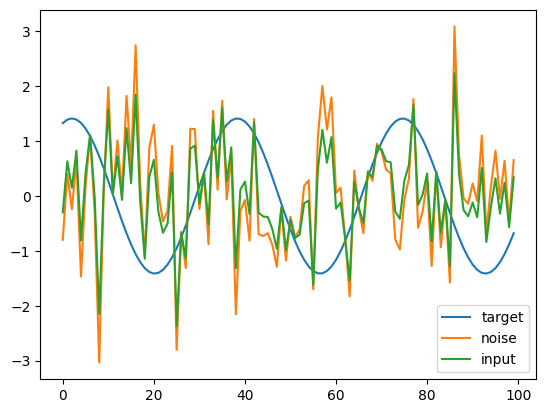

In [2]:
datasets = create_dataset(
    config=DatasetConfig(
        train_num=100,
        lf0_low=5.7,
        lf0_high=6.7,
        sampling_rate=24000,
        min_sampling_length=100,
        max_sampling_length=100,
        test_num=100,
        seed=0,
    ),
)

datas = datasets["train"]
for d in [datas[0]]:
    plt.plot(d["target_wave"].numpy(), label="target")
    plt.plot(d["noise_wave"].numpy(), label="noise")
    plt.plot(d["input_wave"].numpy(), label="input")
    # plt.plot(d["target_wave"].numpy() - d["noise_wave"].numpy(), label="diff")
    print(d["t"])
    plt.legend()

### 生成してみる
* 300エポック（50000イテレーション）くらいのモデルだと、ステップ30くらいかければかなりきれいなサイン波が作れる。
* ステップ数を大幅に増やすと逆効果になる。
* より小さいモデルで学習させたとき、エポック数も増やしていくと逆に波が汚くなっていった。

(-2.3, 2.3)

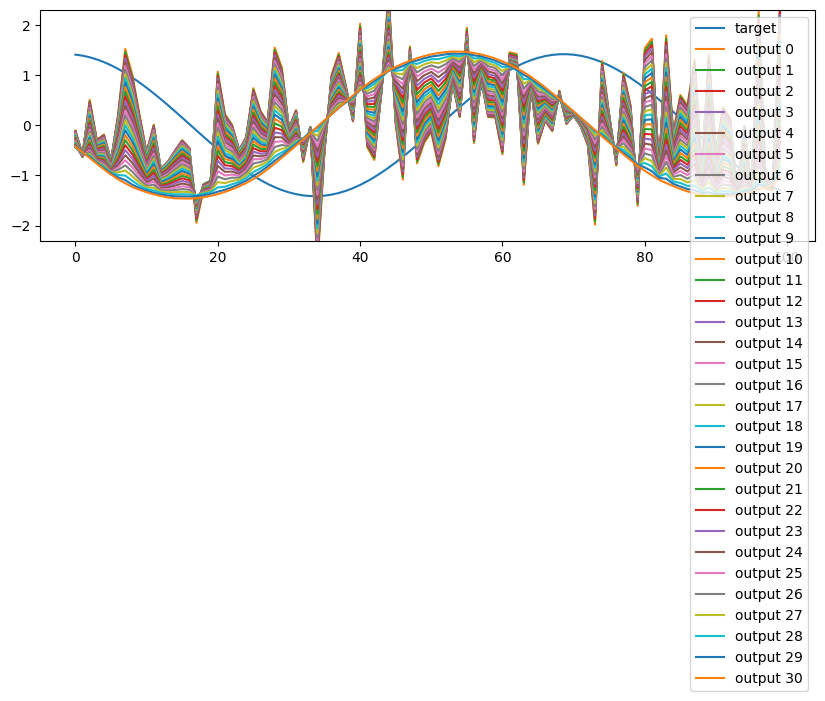

In [60]:
config_yaml_path = Path("config.yaml")
predictor_path = Path("predictor_295.pth")

with config_yaml_path.open() as f:
    config_dict = yaml.safe_load(f)
config = Config.from_dict(config_dict)

generator = Generator(config=config, predictor=predictor_path, use_gpu=True)
# generator = Generator(config=config, predictor=predictor_path, use_gpu=False)

datas = datasets["test"]
d = datas[len(datas) // 2]

output_steps = generator(
    noise_wave_list=[d["noise_wave"]],
    lf0_list=[d["lf0"]],
    step_num=30,
    return_every_step=True,
)

fig = plt.figure(figsize=(10, 3))
plt.plot(d["target_wave"].numpy(), label="target")
# for i, output in enumerate(output_steps[-1:]):
for i, output in enumerate(output_steps):
    plt.plot(output[0]["wave"].detach().cpu().numpy(), label=f"output {i}")
    plt.legend()
plt.ylim(-2.3, 2.3)